# RFM Feature Engineering and Clustering

This notebook converts parsed raw transactions into a **customer-level segmentation mart** using two complementary approaches:

1. **Rule-based RFM segments** (high actionability)
2. **Unsupervised clustering** (pattern discovery)


## What This Notebook Produces

- Reusable parser for the raw mixed-structure CSV (`Customer-*` headers + transaction rows)
- Customer-level RFM table (`recency`, `frequency`, `monetary`) with quantile scores
- Rule-driven customer segments (`segment_rfm`)
- K-means cluster segments (`segment_cluster`) with K-selection diagnostics
- Unified segment-vs-cluster comparison views


In [1]:
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 180)

try:
    from IPython.display import display
except Exception:
    def display(obj):
        print(obj)

THEME = {
    "bg": "#f4f6fb",
    "panel": "#ffffff",
    "ink": "#1f2937",
    "muted": "#6b7280",
    "grid": "#d7dde8",
    "accent": "#0f766e",
    "accent_alt": "#1d4ed8",
    "accent_warm": "#d97706",
    "danger": "#b91c1c",
}

SEGMENT_COLORS = {
    "Champions": "#0f766e",
    "Loyal Customers": "#1d4ed8",
    "Potential Loyalists": "#38bdf8",
    "At Risk (High Value)": "#b91c1c",
    "Big Spenders Cooling": "#f97316",
    "Lost / Hibernating": "#6b7280",
    "Need Attention": "#a78bfa",
}

def apply_theme() -> None:
    mpl.rcParams.update({
        "figure.facecolor": THEME["bg"],
        "axes.facecolor": THEME["panel"],
        "axes.edgecolor": THEME["grid"],
        "axes.labelcolor": THEME["ink"],
        "axes.titleweight": "bold",
        "axes.titlecolor": THEME["ink"],
        "xtick.color": THEME["muted"],
        "ytick.color": THEME["muted"],
        "grid.color": THEME["grid"],
        "grid.linewidth": 0.8,
        "axes.grid": True,
        "axes.axisbelow": True,
        "font.size": 11,
        "font.family": "DejaVu Sans",
    })

def fmt_millions(v, _):
    return f"{v/1_000_000:.1f}M"

def fmt_thousands(v, _):
    return f"{v/1_000:.0f}K"

apply_theme()

In [2]:
def resolve_data_path() -> Path:
    candidates = [
        Path("/kaggle/input/raw-sales-dataset-for-rfm-customer-segmentation/raw_rfm_sales_transactions_30000.csv"),
        Path("dataset/raw_rfm_sales_transactions_30000.csv"),
        Path("../dataset/raw_rfm_sales_transactions_30000.csv"),
        Path("raw_rfm_sales_transactions_30000.csv"),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(
        "Dataset not found in Kaggle or local paths. Checked: " + ", ".join(str(p) for p in candidates)
    )

def parse_raw_transactions(data_path: Path):
    raw = pd.read_csv(data_path)
    raw.columns = raw.columns.str.strip().str.lower().str.replace(" ", "_", regex=False)

    is_header = raw["transaction_id"].astype(str).str.startswith("Customer-", na=False)
    is_tx = raw["transaction_id"].astype(str).str.startswith("T", na=False)

    context = raw[["transaction_id", "date"]].copy()
    context["customer_id"] = np.where(is_header, raw["transaction_id"], np.nan)
    context["region"] = np.where(is_header, raw["date"], np.nan)
    context[["customer_id", "region"]] = context[["customer_id", "region"]].ffill()

    tx = raw.loc[is_tx].copy()
    tx[["customer_id", "region"]] = context.loc[is_tx, ["customer_id", "region"]].values

    for col in ["product_id", "product_name", "product_category", "customer_id", "region"]:
        tx[col] = tx[col].astype(str).str.strip()

    tx["region"] = tx["region"].str.title()
    tx["date"] = pd.to_datetime(tx["date"], dayfirst=True, errors="coerce")
    tx["quantity"] = pd.to_numeric(tx["quantity"], errors="coerce")

    for col in ["ppu", "amount"]:
        tx[col] = pd.to_numeric(tx[col].astype(str).str.replace(",", "", regex=False), errors="coerce")

    tx["expected_amount"] = tx["quantity"] * tx["ppu"]
    tx["amount_gap"] = tx["amount"] - tx["expected_amount"]
    tx = tx.sort_values("date").reset_index(drop=True)

    qa = {
        "raw_rows": int(raw.shape[0]),
        "header_rows": int(is_header.sum()),
        "transaction_rows": int(tx.shape[0]),
        "unique_customers": int(tx["customer_id"].nunique()),
        "unique_regions": int(tx["region"].nunique()),
        "date_parse_failures": int(tx["date"].isna().sum()),
        "numeric_parse_failures": int(tx[["quantity", "ppu", "amount"]].isna().sum().sum()),
        "amount_integrity_mismatches": int((tx["amount_gap"].abs() > 1e-6).sum()),
        "duplicate_transaction_ids": int(tx["transaction_id"].duplicated().sum()),
    }
    return raw, tx, qa

def mode_or_first(series: pd.Series) -> str:
    modes = series.mode(dropna=True)
    if len(modes) > 0:
        return str(modes.iloc[0])
    return str(series.iloc[0])

def quantile_rank_score(series: pd.Series, high_is_good: bool = True, bins: int = 5) -> pd.Series:
    # Tie handling strategy: average rank before percentile binning.
    pct_rank = series.rank(method="average", pct=True, ascending=True)
    scores = np.ceil(pct_rank * bins).astype(int).clip(1, bins)
    if not high_is_good:
        scores = bins + 1 - scores
    return pd.Series(scores, index=series.index)

data_path = resolve_data_path()
raw, tx, qa = parse_raw_transactions(data_path)

print(f"Resolved data path: {data_path}")
print(f"Parsed transactions: {tx.shape[0]:,}")
qa_df = pd.DataFrame({"Metric": qa.keys(), "Value": qa.values()})
display(qa_df)
display(tx.head(5))

Resolved data path: /kaggle/input/raw-sales-dataset-for-rfm-customer-segmentation/raw_rfm_sales_transactions_30000.csv
Parsed transactions: 30,000


,Metric,Value
0,raw_rows,30100
1,header_rows,100
2,transaction_rows,30000
3,unique_customers,100
4,unique_regions,5
5,date_parse_failures,0
6,numeric_parse_failures,0
7,amount_integrity_mismatches,0
8,duplicate_transaction_ids,0


,transaction_id,date,product_id,product_name,product_category,quantity,ppu,amount,customer_id,region,expected_amount,amount_gap
0,T000001,2025-01-01,PROD-008,Executive Ballpoint Pen Box,Office Supplies,8.0,70000,560000,Customer-001,Yangon,560000.0,0.0
1,T000037,2025-01-01,PROD-010,Webcam 1080p HD,Electronics,2.0,180000,360000,Customer-022,Mandalay,360000.0,0.0
2,T000038,2025-01-01,PROD-010,Webcam 1080p HD,Electronics,5.0,180000,900000,Customer-023,Mandalay,900000.0,0.0
3,T000039,2025-01-01,PROD-001,Ergonomic Mesh Chair,Furniture,8.0,750000,6000000,Customer-023,Mandalay,6000000.0,0.0
4,T000040,2025-01-01,PROD-010,Webcam 1080p HD,Electronics,7.0,180000,1260000,Customer-023,Mandalay,1260000.0,0.0


## RFM Feature Engineering

**Reference date** is fixed to `max(transaction_date) + 1 day`.

- `Recency`: days since last transaction (lower is better)
- `Frequency`: number of transactions (higher is better)
- `Monetary`: cumulative revenue per customer (higher is better)


In [3]:
reference_date = tx["date"].max() + pd.Timedelta(days=1)

customer_region = (
    tx.groupby("customer_id")["region"]
    .agg(mode_or_first)
    .rename("region")
)

customer_rfm = (
    tx.groupby("customer_id", as_index=False)
    .agg(
        last_tx_date=("date", "max"),
        frequency=("transaction_id", "count"),
        frequency_active_days=("date", "nunique"),
        monetary=("amount", "sum"),
    )
)

customer_rfm["recency"] = (reference_date - customer_rfm["last_tx_date"]).dt.days
customer_rfm = customer_rfm.merge(customer_region.reset_index(), on="customer_id", how="left")

customer_rfm["r_score"] = quantile_rank_score(customer_rfm["recency"], high_is_good=False, bins=5)
customer_rfm["f_score"] = quantile_rank_score(customer_rfm["frequency"], high_is_good=True, bins=5)
customer_rfm["m_score"] = quantile_rank_score(customer_rfm["monetary"], high_is_good=True, bins=5)

customer_rfm["rfm_sum_score"] = customer_rfm[["r_score", "f_score", "m_score"]].sum(axis=1)
customer_rfm["rfm_avg_score"] = customer_rfm[["r_score", "f_score", "m_score"]].mean(axis=1).round(2)
customer_rfm["rfm_code"] = (
    customer_rfm["r_score"].astype(str)
    + customer_rfm["f_score"].astype(str)
    + customer_rfm["m_score"].astype(str)
)

customer_rfm = customer_rfm[[
    "customer_id", "region", "recency", "frequency", "frequency_active_days", "monetary",
    "r_score", "f_score", "m_score", "rfm_sum_score", "rfm_avg_score", "rfm_code", "last_tx_date"
]].sort_values(["rfm_sum_score", "monetary"], ascending=[False, False]).reset_index(drop=True)

print(f"Reference date: {reference_date.date()}")
print(f"Customers in RFM table: {customer_rfm.shape[0]}")
display(customer_rfm.head(10))

Reference date: 2025-07-01
Customers in RFM table: 100


,customer_id,region,recency,frequency,frequency_active_days,monetary,r_score,f_score,m_score,rfm_sum_score,rfm_avg_score,rfm_code,last_tx_date
0,Customer-094,Mandalay,1,329,149,850629000,5,5,5,15,5.00,555,2025-06-30
1,Customer-093,Mandalay,1,330,159,805415000,5,5,5,15,5.00,555,2025-06-30
2,Customer-087,Naypyitaw,1,318,142,794238000,5,5,5,15,5.00,555,2025-06-30
3,Customer-031,Bago,1,309,149,842388500,5,4,5,14,4.67,545,2025-06-30
4,Customer-096,Taunggyi,1,313,156,829229500,5,4,5,14,4.67,545,2025-06-30
5,Customer-016,Taunggyi,1,344,159,788311000,5,5,4,14,4.67,554,2025-06-30
6,Customer-088,Bago,1,315,140,787382500,5,5,4,14,4.67,554,2025-06-30
7,Customer-001,Yangon,1,322,158,784745000,5,5,4,14,4.67,554,2025-06-30
8,Customer-015,Naypyitaw,1,297,144,825326000,5,3,5,13,4.33,535,2025-06-30
9,Customer-020,Taunggyi,32,320,132,820514500,3,5,5,13,4.33,355,2025-05-30


## Rule-Based RFM Segments

Segment assignment uses ordered business rules, prioritizing high-value and high-risk groups first.


In [4]:
r = customer_rfm["r_score"]
f = customer_rfm["f_score"]
m = customer_rfm["m_score"]

segment_conditions = [
    (r >= 4) & (f >= 4) & (m >= 4),
    (r >= 3) & (f >= 4) & (m >= 3),
    (r >= 4) & (f >= 2) & (m >= 2),
    (r <= 2) & (f >= 4) & (m >= 4),
    (m >= 4) & (r <= 3),
    (r <= 2) & (f <= 2) & (m <= 2),
]

segment_labels = [
    "Champions",
    "Loyal Customers",
    "Potential Loyalists",
    "At Risk (High Value)",
    "Big Spenders Cooling",
    "Lost / Hibernating",
]

customer_rfm["segment_rfm"] = np.select(segment_conditions, segment_labels, default="Need Attention")

segment_definition = pd.DataFrame({
    "Segment": [
        "Champions",
        "Loyal Customers",
        "Potential Loyalists",
        "At Risk (High Value)",
        "Big Spenders Cooling",
        "Lost / Hibernating",
        "Need Attention",
    ],
    "Rule": [
        "R>=4, F>=4, M>=4",
        "R>=3, F>=4, M>=3",
        "R>=4, F>=2, M>=2",
        "R<=2, F>=4, M>=4",
        "M>=4 and R<=3",
        "R<=2, F<=2, M<=2",
        "All remaining customers",
    ],
    "Intent": [
        "Protect and upsell premium loyalty",
        "Retain and increase basket depth",
        "Nurture toward long-term loyalty",
        "Immediate reactivation program",
        "Prevent spending decay",
        "Low-priority re-engagement",
        "Observe and personalize (default)",
    ],
})

display(segment_definition)

segment_profile = (
    customer_rfm.groupby("segment_rfm", as_index=False)
    .agg(
        customers=("customer_id", "count"),
        recency_mean=("recency", "mean"),
        frequency_mean=("frequency", "mean"),
        monetary_mean=("monetary", "mean"),
        rfm_sum_mean=("rfm_sum_score", "mean"),
        total_revenue=("monetary", "sum"),
    )
)
segment_profile["customer_share_pct"] = 100 * segment_profile["customers"] / segment_profile["customers"].sum()
segment_profile["revenue_share_pct"] = 100 * segment_profile["total_revenue"] / segment_profile["total_revenue"].sum()
segment_profile = segment_profile.sort_values("total_revenue", ascending=False)

display(
    segment_profile.style.format({
        "recency_mean": "{:.1f}",
        "frequency_mean": "{:.1f}",
        "monetary_mean": "{:,.0f}",
        "rfm_sum_mean": "{:.2f}",
        "total_revenue": "{:,.0f}",
        "customer_share_pct": "{:.1f}%",
        "revenue_share_pct": "{:.1f}%",
    })
)

,Segment,Rule,Intent
0,Champions,"R>=4, F>=4, M>=4",Protect and upsell premium loyalty
1,Loyal Customers,"R>=3, F>=4, M>=3",Retain and increase basket depth
2,Potential Loyalists,"R>=4, F>=2, M>=2",Nurture toward long-term loyalty
3,At Risk (High Value),"R<=2, F>=4, M>=4",Immediate reactivation program
4,Big Spenders Cooling,M>=4 and R<=3,Prevent spending decay
5,Lost / Hibernating,"R<=2, F<=2, M<=2",Low-priority re-engagement
6,Need Attention,All remaining customers,Observe and personalize (default)


,segment_rfm,customers,recency_mean,frequency_mean,monetary_mean,rfm_sum_mean,total_revenue,customer_share_pct,revenue_share_pct
5,Need Attention,34,38.6,291.1,"700,108,074",7.47,"23,803,674,500",34.0%,32.1%
6,Potential Loyalists,17,1.0,299.5,"738,632,853",10.76,"12,556,758,500",17.0%,17.0%
0,At Risk (High Value),13,116.6,315.8,"807,103,654",10.38,"10,492,347,500",13.0%,14.2%
3,Lost / Hibernating,11,109.3,283.6,"676,161,409",4.36,"7,437,775,500",11.0%,10.0%
2,Champions,9,1.0,321.2,"805,351,667",14.22,"7,248,165,000",9.0%,9.8%
1,Big Spenders Cooling,8,97.2,294.8,"786,329,562",8.25,"6,290,636,500",8.0%,8.5%
4,Loyal Customers,8,20.6,317.1,"777,946,500",12.00,"6,223,572,000",8.0%,8.4%


## Clustering-Based Segmentation (K-Means + Optional GMM)

Modeling steps:
- use `recency`, `frequency`, `monetary`
- stabilize skew via `log1p`
- robust-scale the transformed features
- evaluate candidate K values
- select K for final cluster assignment


In [5]:
feature_cols = ["recency", "frequency", "monetary"]
X_raw = customer_rfm[feature_cols].copy()
X_model = np.log1p(X_raw)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_model)

k_records = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = km.fit_predict(X_scaled)
    k_records.append({
        "k": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_scaled, labels),
    })

k_eval = pd.DataFrame(k_records)

# Actionability prior: prefer 4-6 clusters for compact CRM playbooks.
k_window = k_eval[k_eval["k"].between(4, 6)].copy()
selected_k = int(k_window.sort_values(["silhouette", "k"], ascending=[False, True]).iloc[0]["k"])

display(k_eval)
print(f"Selected K: {selected_k} (best silhouette within K=4..6 actionability window)")

,k,inertia,silhouette
0,2,69.004295,0.349714
1,3,53.117735,0.279228
2,4,40.994338,0.324755
3,5,34.834454,0.337168
4,6,29.073976,0.345179
5,7,24.035574,0.368042
6,8,21.374940,0.374779


Selected K: 6 (best silhouette within K=4..6 actionability window)


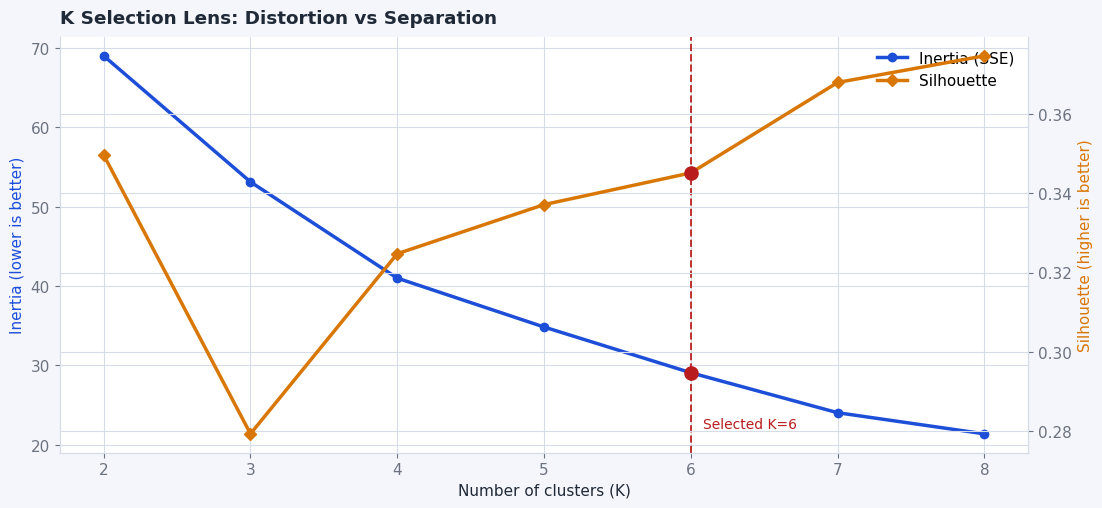

In [6]:
fig, ax1 = plt.subplots(figsize=(12.5, 5.4))
ax2 = ax1.twinx()

ax1.plot(k_eval["k"], k_eval["inertia"], color=THEME["accent_alt"], marker="o", linewidth=2.5, label="Inertia (SSE)")
ax2.plot(k_eval["k"], k_eval["silhouette"], color=THEME["accent_warm"], marker="D", linewidth=2.5, label="Silhouette")

ax1.scatter([selected_k], [k_eval.loc[k_eval["k"] == selected_k, "inertia"].iloc[0]], color=THEME["danger"], s=90, zorder=6)
ax2.scatter([selected_k], [k_eval.loc[k_eval["k"] == selected_k, "silhouette"].iloc[0]], color=THEME["danger"], s=90, zorder=6)

ax1.axvline(selected_k, linestyle="--", color=THEME["danger"], linewidth=1.4, alpha=0.9)
ax1.text(selected_k + 0.08, ax1.get_ylim()[0] + (ax1.get_ylim()[1] - ax1.get_ylim()[0]) * 0.06,
         f"Selected K={selected_k}", color=THEME["danger"], fontsize=10)

ax1.set_xlabel("Number of clusters (K)")
ax1.set_ylabel("Inertia (lower is better)", color=THEME["accent_alt"])
ax2.set_ylabel("Silhouette (higher is better)", color=THEME["accent_warm"])
ax1.set_xticks(k_eval["k"])
ax1.set_title("K Selection Lens: Distortion vs Separation", loc="left", pad=10)

ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right", frameon=False)
plt.show()

In [7]:
kmeans = KMeans(n_clusters=selected_k, random_state=42, n_init=100)
cluster_id = kmeans.fit_predict(X_scaled)
customer_rfm["cluster_id"] = cluster_id

cluster_order = (
    customer_rfm.groupby("cluster_id")["monetary"]
    .mean()
    .sort_values(ascending=False)
    .index
)
cluster_map = {cid: f"C{i+1}" for i, cid in enumerate(cluster_order)}
customer_rfm["segment_cluster"] = customer_rfm["cluster_id"].map(cluster_map)

# Optional second method for pattern robustness check.
gmm = GaussianMixture(n_components=selected_k, random_state=42)
customer_rfm["cluster_gmm"] = gmm.fit_predict(X_scaled)

sil_kmeans = silhouette_score(X_scaled, customer_rfm["cluster_id"])
sil_gmm = silhouette_score(X_scaled, customer_rfm["cluster_gmm"])
ari_km_gmm = adjusted_rand_score(customer_rfm["cluster_id"], customer_rfm["cluster_gmm"])

print(f"Silhouette (KMeans): {sil_kmeans:.3f}")
print(f"Silhouette (GMM):    {sil_gmm:.3f}")
print(f"Agreement KMeans vs GMM (ARI): {ari_km_gmm:.3f}")

cluster_profile = (
    customer_rfm.groupby("segment_cluster", as_index=False)
    .agg(
        customers=("customer_id", "count"),
        recency_mean=("recency", "mean"),
        frequency_mean=("frequency", "mean"),
        monetary_mean=("monetary", "mean"),
        r_score_mean=("r_score", "mean"),
        f_score_mean=("f_score", "mean"),
        m_score_mean=("m_score", "mean"),
        total_revenue=("monetary", "sum"),
    )
    .sort_values("monetary_mean", ascending=False)
)
cluster_profile["customer_share_pct"] = 100 * cluster_profile["customers"] / cluster_profile["customers"].sum()
cluster_profile["revenue_share_pct"] = 100 * cluster_profile["total_revenue"] / cluster_profile["total_revenue"].sum()

display(
    cluster_profile.style.format({
        "recency_mean": "{:.1f}",
        "frequency_mean": "{:.1f}",
        "monetary_mean": "{:,.0f}",
        "r_score_mean": "{:.2f}",
        "f_score_mean": "{:.2f}",
        "m_score_mean": "{:.2f}",
        "total_revenue": "{:,.0f}",
        "customer_share_pct": "{:.1f}%",
        "revenue_share_pct": "{:.1f}%",
    })
)

Silhouette (KMeans): 0.345
Silhouette (GMM):    -0.039
Agreement KMeans vs GMM (ARI): 0.311


,segment_cluster,customers,recency_mean,frequency_mean,monetary_mean,r_score_mean,f_score_mean,m_score_mean,total_revenue,customer_share_pct,revenue_share_pct
0,C1,14,92.8,318.4,"820,116,107",1.79,4.50,4.79,"11,481,625,500",14.0%,15.5%
1,C2,17,1.2,314.6,"797,391,824",4.76,4.18,4.41,"13,555,661,000",17.0%,18.3%
2,C3,21,98.7,303.0,"742,287,262",1.67,3.29,3.19,"15,588,032,500",21.0%,21.0%
3,C4,22,1.3,298.1,"717,667,205",4.64,2.77,2.32,"15,788,678,500",22.0%,21.3%
4,C5,14,103.4,284.1,"692,980,000",1.57,1.50,1.71,"9,701,720,000",14.0%,13.1%
5,C6,12,10.9,274.3,"661,434,333",3.92,1.08,1.33,"7,937,212,000",12.0%,10.7%


## Unified Segmentation View

`segment_rfm` provides direct campaign logic, while `segment_cluster` may reveal hidden structure inside the same rule segment.


In [8]:
segment_cluster_ct = pd.crosstab(customer_rfm["segment_rfm"], customer_rfm["segment_cluster"])
segment_cluster_pct = segment_cluster_ct.div(segment_cluster_ct.sum(axis=1), axis=0)

segment_rev = customer_rfm.groupby("segment_rfm", as_index=False).agg(customers=("customer_id", "count"), revenue=("monetary", "sum"))
cluster_rev = customer_rfm.groupby("segment_cluster", as_index=False).agg(customers=("customer_id", "count"), revenue=("monetary", "sum"))

print("Rule segment x cluster overlap (counts)")
display(segment_cluster_ct)
print("Rule segment x cluster overlap (row %)")
display((segment_cluster_pct * 100).round(1))

print("Segment summary metric")
display(segment_rev.sort_values("revenue", ascending=False))
print("Cluster summary metric")
display(cluster_rev.sort_values("revenue", ascending=False))

Rule segment x cluster overlap (counts)


segment_cluster,C1,C2,C3,C4,C5,C6
segment_rfm,,,,,,
At Risk (High Value),10,0,3,0,0,0
Big Spenders Cooling,1,1,5,0,1,0
Champions,0,9,0,0,0,0
Lost / Hibernating,0,0,0,0,10,1
Loyal Customers,3,3,2,0,0,0
Need Attention,0,0,11,9,3,11
Potential Loyalists,0,4,0,13,0,0


Rule segment x cluster overlap (row %)


segment_cluster,C1,C2,C3,C4,C5,C6
segment_rfm,,,,,,
At Risk (High Value),76.9,0.0,23.1,0.0,0.0,0.0
Big Spenders Cooling,12.5,12.5,62.5,0.0,12.5,0.0
Champions,0.0,100.0,0.0,0.0,0.0,0.0
Lost / Hibernating,0.0,0.0,0.0,0.0,90.9,9.1
Loyal Customers,37.5,37.5,25.0,0.0,0.0,0.0
Need Attention,0.0,0.0,32.4,26.5,8.8,32.4
Potential Loyalists,0.0,23.5,0.0,76.5,0.0,0.0


Segment summary metric


,segment_rfm,customers,revenue
5,Need Attention,34,23803674500
6,Potential Loyalists,17,12556758500
0,At Risk (High Value),13,10492347500
3,Lost / Hibernating,11,7437775500
2,Champions,9,7248165000
1,Big Spenders Cooling,8,6290636500
4,Loyal Customers,8,6223572000


Cluster summary metric


,segment_cluster,customers,revenue
3,C4,22,15788678500
2,C3,21,15588032500
1,C2,17,13555661000
0,C1,14,11481625500
4,C5,14,9701720000
5,C6,12,7937212000


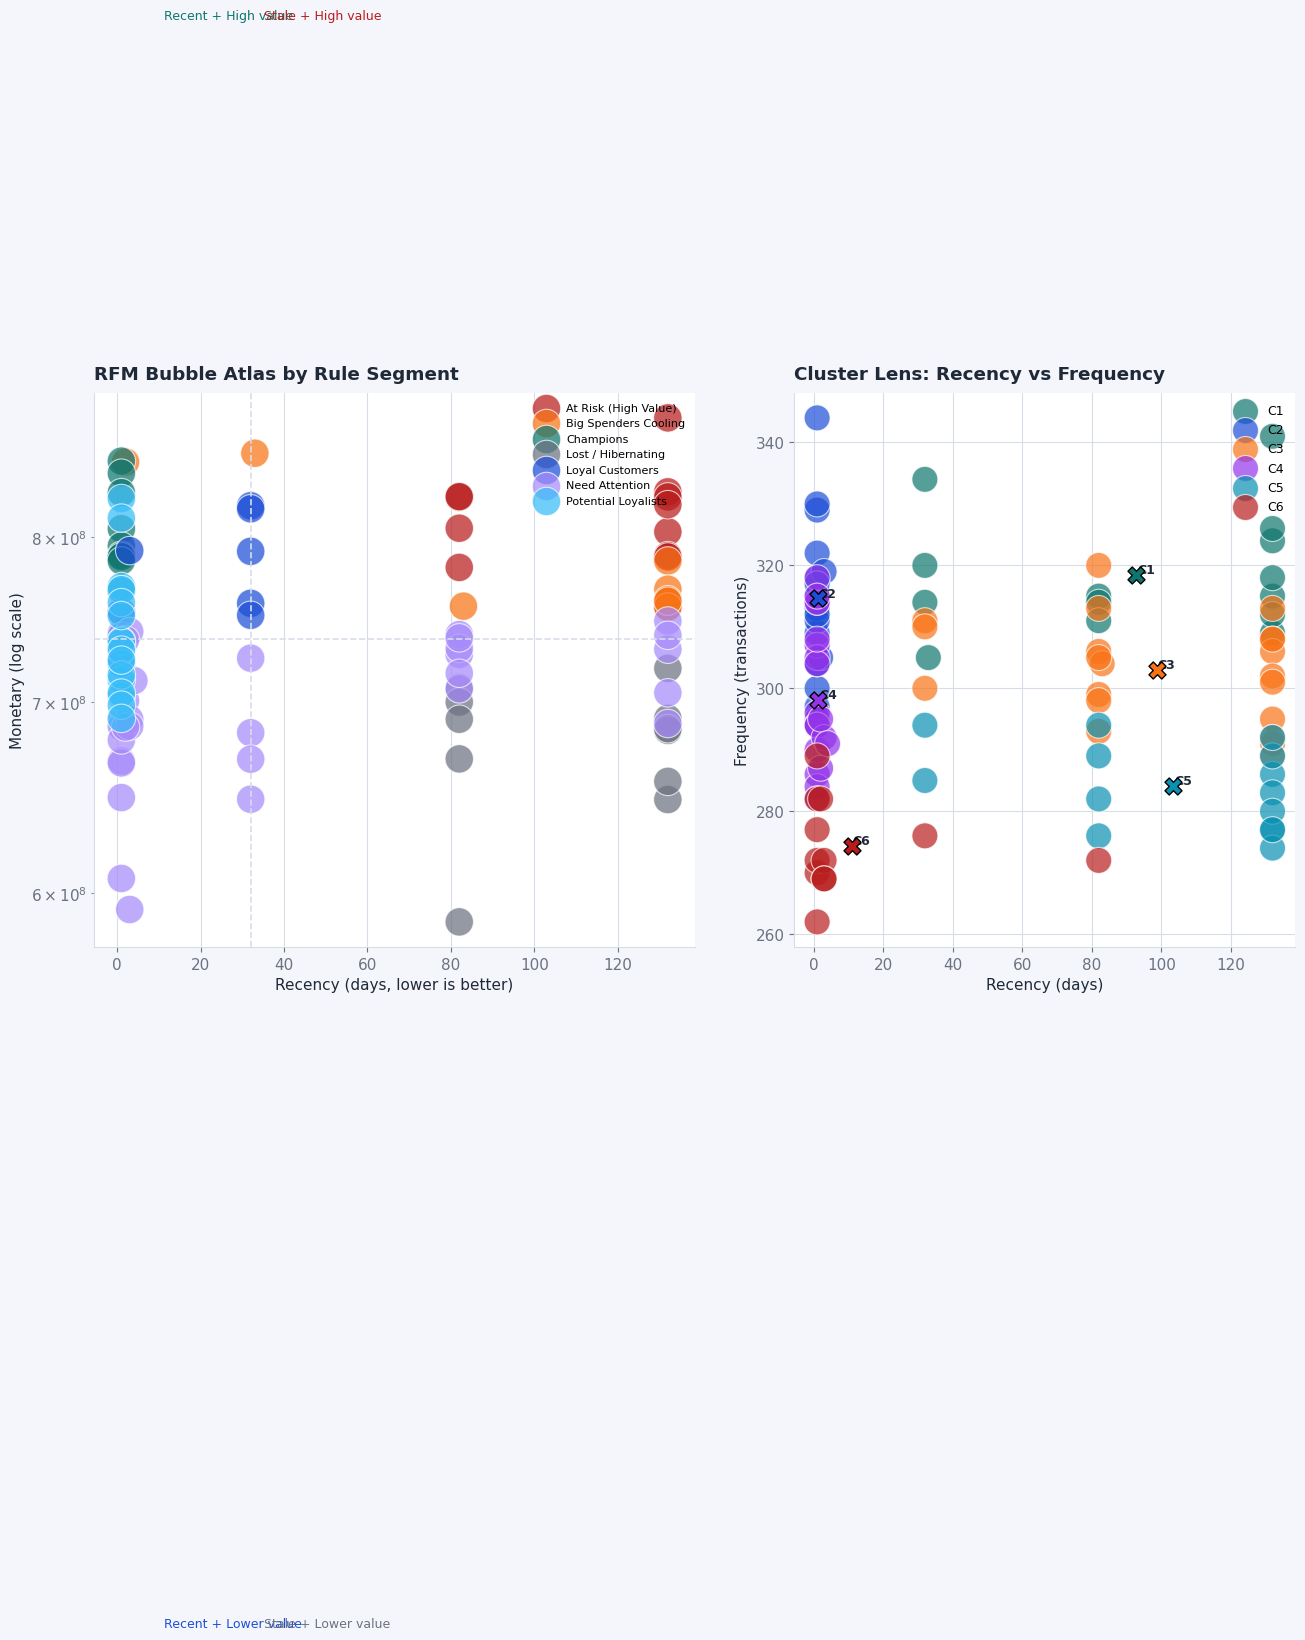

In [9]:
# Dynamic cluster palette
cluster_labels_sorted = sorted(customer_rfm["segment_cluster"].unique(), key=lambda x: int(str(x).replace("C", "")))
cluster_palette_colors = ["#0f766e", "#1d4ed8", "#f97316", "#9333ea", "#0891b2", "#b91c1c", "#65a30d", "#374151"]
CLUSTER_COLORS = {c: cluster_palette_colors[i % len(cluster_palette_colors)] for i, c in enumerate(cluster_labels_sorted)}

fig = plt.figure(figsize=(15.5, 7.2))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.2, 1], wspace=0.18)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Panel 1: R vs M bubble atlas colored by rule segment
for seg, df_seg in customer_rfm.groupby("segment_rfm"):
    color = SEGMENT_COLORS.get(seg, "#94a3b8")
    ax1.scatter(
        df_seg["recency"],
        df_seg["monetary"],
        s=np.clip(df_seg["frequency"] * 5, 40, 420),
        color=color,
        alpha=0.72,
        edgecolor="white",
        linewidth=0.8,
        label=seg,
    )

rx = customer_rfm["recency"].median()
my = customer_rfm["monetary"].median()
ax1.axvline(rx, linestyle="--", color=THEME["grid"], linewidth=1.2)
ax1.axhline(my, linestyle="--", color=THEME["grid"], linewidth=1.2)
ax1.set_yscale("log")
ax1.yaxis.set_major_formatter(FuncFormatter(fmt_millions))
ax1.set_xlabel("Recency (days, lower is better)")
ax1.set_ylabel("Monetary (log scale)")
ax1.set_title("RFM Bubble Atlas by Rule Segment", loc="left", pad=10)
ax1.legend(loc="upper right", frameon=False, fontsize=8)

# Quadrant annotations
ax1.text(rx * 0.35, my * 1.65, "Recent + High value", fontsize=9, color=THEME["accent"])
ax1.text(rx * 1.1, my * 1.65, "Stale + High value", fontsize=9, color=THEME["danger"])
ax1.text(rx * 0.35, my * 0.45, "Recent + Lower value", fontsize=9, color=THEME["accent_alt"])
ax1.text(rx * 1.1, my * 0.45, "Stale + Lower value", fontsize=9, color=THEME["muted"])

# Panel 2: R vs F cluster map with centroids
for cl, df_cl in customer_rfm.groupby("segment_cluster"):
    color = CLUSTER_COLORS[cl]
    ax2.scatter(
        df_cl["recency"],
        df_cl["frequency"],
        s=np.clip(df_cl["monetary"] / 280_000, 30, 350),
        color=color,
        alpha=0.7,
        edgecolor="white",
        linewidth=0.8,
        label=cl,
    )
    cx = df_cl["recency"].mean()
    cy = df_cl["frequency"].mean()
    ax2.scatter([cx], [cy], color=color, edgecolor="black", s=150, marker="X", linewidth=1.0, zorder=6)
    ax2.text(cx + 0.25, cy + 0.25, cl, fontsize=9, color=THEME["ink"], fontweight="bold")

ax2.set_xlabel("Recency (days)")
ax2.set_ylabel("Frequency (transactions)")
ax2.set_title("Cluster Lens: Recency vs Frequency", loc="left", pad=10)
ax2.legend(loc="upper right", frameon=False, fontsize=9)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.show()

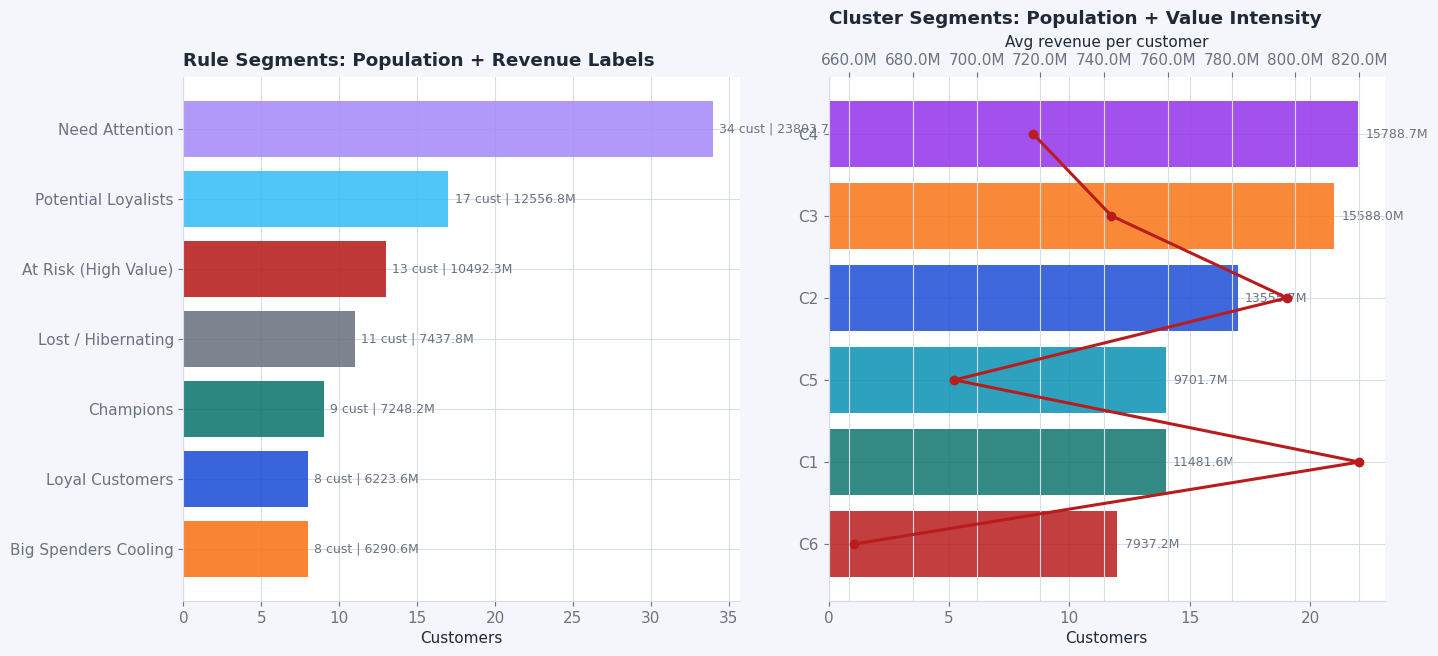

In [10]:
seg_plot = segment_rev.sort_values("customers", ascending=True).copy()
clu_plot = cluster_rev.sort_values("customers", ascending=True).copy()

fig = plt.figure(figsize=(15.5, 6.8))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.16)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Segment bars (customer count) + revenue share labels
bar_colors_seg = [SEGMENT_COLORS.get(s, "#94a3b8") for s in seg_plot["segment_rfm"]]
ax1.barh(seg_plot["segment_rfm"], seg_plot["customers"], color=bar_colors_seg, alpha=0.88)
for y, (_, row) in enumerate(seg_plot.iterrows()):
    ax1.text(row["customers"] + 0.4, y, f"{row['customers']} cust | {row['revenue']/1_000_000:.1f}M", va="center", fontsize=9, color=THEME["muted"])
ax1.set_title("Rule Segments: Population + Revenue Labels", loc="left", pad=8)
ax1.set_xlabel("Customers")

# Cluster bars with line overlay for avg revenue/customer
avg_rev_per_customer = clu_plot["revenue"] / clu_plot["customers"]
bar_colors_clu = [CLUSTER_COLORS.get(c, "#94a3b8") for c in clu_plot["segment_cluster"]]
ax2.barh(clu_plot["segment_cluster"], clu_plot["customers"], color=bar_colors_clu, alpha=0.85)
ax2_t = ax2.twiny()
ax2_t.plot(avg_rev_per_customer, clu_plot["segment_cluster"], color=THEME["danger"], marker="o", linewidth=2.2)

for y, (_, row) in enumerate(clu_plot.iterrows()):
    ax2.text(row["customers"] + 0.3, y, f"{row['revenue']/1_000_000:.1f}M", va="center", fontsize=9, color=THEME["muted"])

ax2.set_title("Cluster Segments: Population + Value Intensity", loc="left", pad=8)
ax2.set_xlabel("Customers")
ax2_t.set_xlabel("Avg revenue per customer")
ax2_t.xaxis.set_major_formatter(FuncFormatter(fmt_millions))

for ax in [ax1, ax2, ax2_t]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.show()

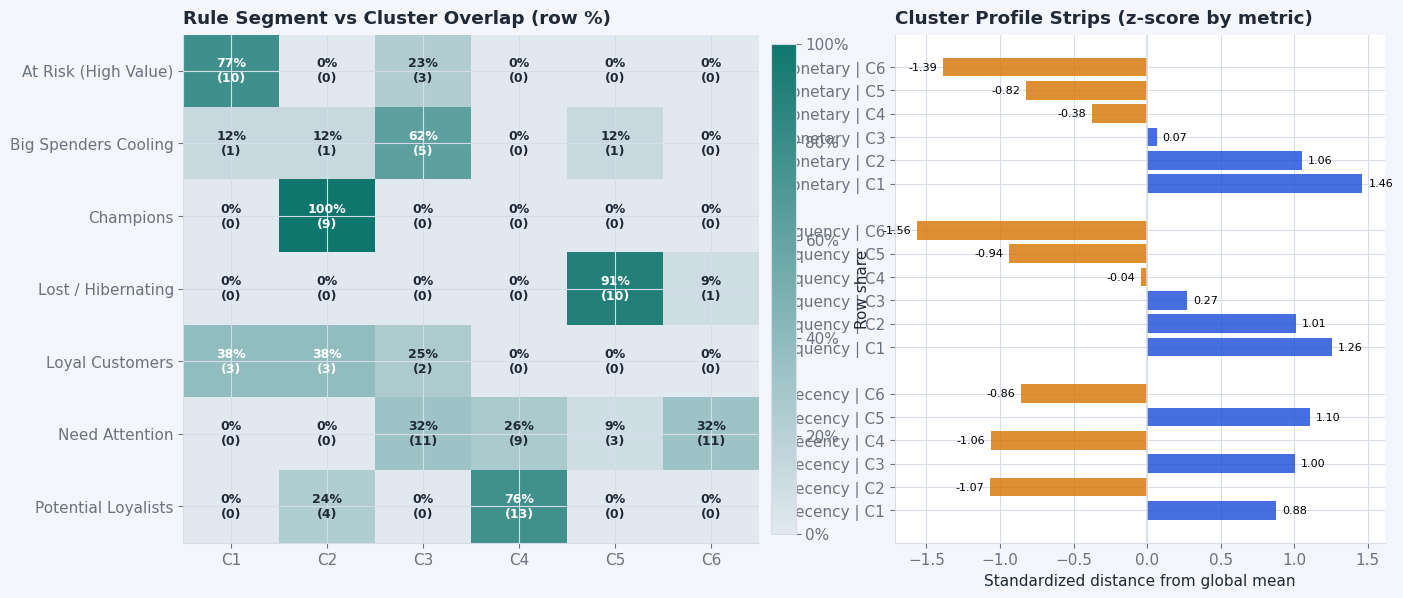

In [11]:
ct = segment_cluster_ct.copy()
ct_pct = ct.div(ct.sum(axis=1), axis=0)

fig = plt.figure(figsize=(15.5, 6.6))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.25, 1], wspace=0.18)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Heatmap: segment-rule x cluster overlap
im = ax1.imshow(ct_pct.values, cmap=mpl.colors.LinearSegmentedColormap.from_list("blend", ["#e2e8f0", "#0f766e"]), aspect="auto")
ax1.set_xticks(np.arange(ct.shape[1]))
ax1.set_xticklabels(ct.columns)
ax1.set_yticks(np.arange(ct.shape[0]))
ax1.set_yticklabels(ct.index)
ax1.set_title("Rule Segment vs Cluster Overlap (row %)", loc="left", pad=8)

for i in range(ct.shape[0]):
    for j in range(ct.shape[1]):
        pct = ct_pct.iloc[i, j] * 100
        cnt = ct.iloc[i, j]
        color = "white" if pct >= 35 else THEME["ink"]
        ax1.text(j, i, f"{pct:.0f}%\n({cnt})", ha="center", va="center", color=color, fontsize=9, fontweight="bold")

cbar = fig.colorbar(im, ax=ax1, fraction=0.04, pad=0.02)
cbar.set_label("Row share")
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v*100:.0f}%"))

# Profile strips: standardized means by cluster (avoid div by zero if a metric is constant)
prof = cluster_profile[["segment_cluster", "recency_mean", "frequency_mean", "monetary_mean"]].copy().set_index("segment_cluster")
stds = prof.std(ddof=0).replace(0, 1)
prof_std = (prof - prof.mean()) / stds

metrics = prof_std.columns.tolist()
for i, metric in enumerate(metrics):
    vals = prof_std[metric].values
    y = np.arange(len(prof_std.index)) + i * (len(prof_std.index) + 1)
    colors = [THEME["accent_alt"] if v >= 0 else THEME["accent_warm"] for v in vals]
    ax2.barh(y, vals, color=colors, alpha=0.82)
    for yi, val in zip(y, vals):
        ax2.text(val + (0.04 if val >= 0 else -0.04), yi, f"{val:.2f}", va="center", ha="left" if val >= 0 else "right", fontsize=8)

yticks = []
yticklabels = []
for i, metric in enumerate(metrics):
    y = np.arange(len(prof_std.index)) + i * (len(prof_std.index) + 1)
    yticks.extend(y.tolist())
    yticklabels.extend([f"{metric.replace('_mean', '').title()} | {idx}" for idx in prof_std.index])

ax2.set_yticks(yticks)
ax2.set_yticklabels(yticklabels)
ax2.axvline(0, color=THEME["grid"], linewidth=1.1)
ax2.set_title("Cluster Profile Strips (z-score by metric)", loc="left", pad=8)
ax2.set_xlabel("Standardized distance from global mean")

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.show()

### Segmentation Analysis

- **Rule-based segments** offer direct action design (retention, win-back, loyalty, upsell).
- **Clusters** add discovery power by splitting customers with similar RFM totals into distinct behavioral density groups.
- The overlap matrix identifies where both methods agree strongly versus where additional feature engineering may improve targeting precision.


In [12]:
# Final export table
final_cols = [
    "customer_id", "region", "recency", "frequency", "frequency_active_days", "monetary",
    "r_score", "f_score", "m_score", "rfm_sum_score", "rfm_avg_score", "rfm_code",
    "segment_rfm", "segment_cluster", "cluster_gmm", "last_tx_date"
]
customers_rfm_segments = customer_rfm[final_cols].sort_values(["segment_cluster", "rfm_sum_score", "monetary"], ascending=[True, False, False]).reset_index(drop=True)

if Path("/kaggle/working").exists():
    output_dir = Path("/kaggle/working/output")
else:
    output_dir = Path("output")

output_dir.mkdir(parents=True, exist_ok=True)
export_path = output_dir / "customers_rfm_segments.csv"
customers_rfm_segments.to_csv(export_path, index=False)

print(f"Exported file: {export_path.resolve()}")
print(f"Rows: {customers_rfm_segments.shape[0]} | Columns: {customers_rfm_segments.shape[1]}")
display(customers_rfm_segments.head(12))

Exported file: /kaggle/working/output/customers_rfm_segments.csv
Rows: 100 | Columns: 16


,customer_id,region,recency,frequency,frequency_active_days,monetary,r_score,f_score,m_score,rfm_sum_score,rfm_avg_score,rfm_code,segment_rfm,segment_cluster,cluster_gmm,last_tx_date
0,Customer-020,Taunggyi,32,320,132,820514500,3,5,5,13,4.33,355,Loyal Customers,C1,3,2025-05-30
1,Customer-040,Naypyitaw,82,315,93,826222000,2,5,5,12,4.00,255,At Risk (High Value),C1,0,2025-04-10
2,Customer-021,Bago,32,314,128,818506000,3,4,5,12,4.00,345,Loyal Customers,C1,3,2025-05-30
3,Customer-027,Taunggyi,32,334,136,790835500,3,5,4,12,4.00,354,Loyal Customers,C1,3,2025-05-30
4,Customer-060,Mandalay,132,324,50,880893000,1,5,5,11,3.67,155,At Risk (High Value),C1,0,2025-02-19
5,Customer-026,Bago,33,305,125,856081000,3,3,5,11,3.67,335,Big Spenders Cooling,C1,5,2025-05-29
6,Customer-064,Mandalay,132,326,50,829782000,1,5,5,11,3.67,155,At Risk (High Value),C1,0,2025-02-19
7,Customer-035,Mandalay,82,314,94,826603000,2,4,5,11,3.67,245,At Risk (High Value),C1,0,2025-04-10
8,Customer-059,Mandalay,132,315,50,826404000,1,5,5,11,3.67,155,At Risk (High Value),C1,0,2025-02-19
9,Customer-041,Bago,82,311,92,805751500,2,4,5,11,3.67,245,At Risk (High Value),C1,0,2025-04-10
